In [1]:
import classification as clf
import regression as rf
import torch
import numpy as np
import pandas as pd
import lime
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from lime import lime_text

from lime.lime_text import LimeTextExplainer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel

2024-04-16 18:20:48.655461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/barajascervantes.a/miniconda3/envs/islp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/barajascervantes.a/miniconda3/envs/islp/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [35]:
FILEPATH_TRAIN = '../res/train.csv'
FILEPATH_TEST = '../res/test.csv'

MAX_LENGTH = 256
BATCH_SIZE = 64

train =clf.load_dataframe(FILEPATH_TRAIN) 
test = clf.load_dataframe(FILEPATH_TEST)

In [3]:
 device = (
        'cuda'
        if torch.cuda.is_available()
        else 'cpu'
    )
print(f'Using {device} device')

Using cpu device


In [4]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [5]:
train_dataset = clf.ReviewDataset(FILEPATH_TRAIN, tokenizer)
print(f'{len(train_dataset)} training samples loaded')

test_dataset = clf.ReviewDataset(FILEPATH_TEST, tokenizer)
print(f'{len(test_dataset)} testing samples loaded')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = clf.RatingModel(hidden_size=1_000).to(device)

72608 training samples loaded
24315 testing samples loaded


/Users/barajascervantes.a/miniconda3/envs/islp/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/barajascervantes.a/miniconda3/envs/islp/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [6]:
print(model)

RatingModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [7]:
PATH_BINARY = "./binaryclass_model_20240414_103223_8"
model.load_state_dict(torch.load(PATH_BINARY,map_location=torch.device('cpu')))

<All keys matched successfully>

In [8]:
def batch_predict(reviews):
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    reviews_inputs = {}
    ids = torch.LongTensor()
    mask = torch.LongTensor()
    n = len(reviews)
    for review in reviews:
        tokens = tokenizer(
            review,
            return_tensors='pt',
            padding='max_length',
            max_length=256,
            truncation=True)
        input_ids = torch.squeeze(tokens['input_ids'])
        attention_mask = torch.squeeze(tokens['attention_mask'])
        ids = torch.cat((ids ,input_ids),dim=0)
        mask = torch.cat((mask, attention_mask),dim=0)
    ids = ids.view(n,-1).type(torch.LongTensor)
    mask = mask.view(n,-1).type(torch.LongTensor)
    reviews_inputs = dict(input_ids=ids, attention_mask=mask)
    model.eval()
    reviews_inputs['input_ids'] = reviews_inputs['input_ids'].to(device)
    reviews_inputs['attention_mask'] = reviews_inputs['attention_mask'].to(device)
    outputs = model(reviews_inputs)
    return outputs.detach().cpu().numpy()

In [9]:
unique_drugs, freq_drugs = np.unique(test.drug_name.values, return_counts=True)

In [10]:
len(unique_drugs)

2637

In [11]:
def get_freq(x_number):
    x = np.random.randint(low=0, high=2130)
    val= freq_drugs[x]
    while val < x_number:
        x = np.random.randint(low=0, high=2130)
        val = freq_drugs[x]
        drug = unique_drugs[x]
    print(val, drug)

In [12]:
get_freq(20)

39 pramipexole


Get reviews by drug: 

In [36]:
# First get rating 1 and 10
test = test[(test.rating == 1) | (test.rating == 10)]
test['rating'] = np.where(test.rating < 5, 0,1)
rev_drug = test[test.drug_name == 'restoril']
revws = rev_drug.review.values

In [39]:
revws.shape

(12,)

In [15]:
probs = batch_predict(revws)

In [16]:
probs.shape

(12, 2)

In [17]:
probs[7]

array([0.21326236, 0.72694135], dtype=float32)

In [77]:
def get_explainability(idx, reviews, batch_predict ,num_samples=200 ,num_features=10):
    class_names = ["negative", "positive"]
    revws = reviews.review.values
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(revws[idx], batch_predict, num_samples=num_samples,num_features=num_features)
    print('Review to explain: \n', revws[idx])
    print('Document id: %d' % idx)
    print('Probability(positive) =', batch_predict([revws[idx]])[0,1])
    print('True class: %s' % class_names[reviews.rating.iloc[idx]] )
    %matplotlib inline
    fig = exp.as_pyplot_figure()
    return exp.as_list()

In [72]:
def get_explainability_custom(idx, reviews, list_words ,batch_predict ,num_samples=200 ,num_features=10):
    class_names = ["negative", "positive"]
    revws = reviews.review.values
    tokens = reviews.review.iloc[idx].split()
    review_removed = [word for word in tokens if not word in list_words_remove]
    review_removed = ' '.join(review_removed)
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(review_removed, batch_predict, num_samples=num_samples,num_features=num_features)
    print('Review to explain: \n', review_removed)
    print('Document id: %d' % idx)
    print('Probability(positive) =', batch_predict([review_removed])[0,1])
    print('True class: %s' % class_names[reviews.rating.iloc[idx]] )
    return exp.as_list()

Checking a positive label

Review to explain: 
 Restoril helps me get to sleep and helps prevent me from waking up constantly during the night. I have had no side-effects from Restoril.
Document id: 7
Probability(positive) = 0.7269413
True class: positive


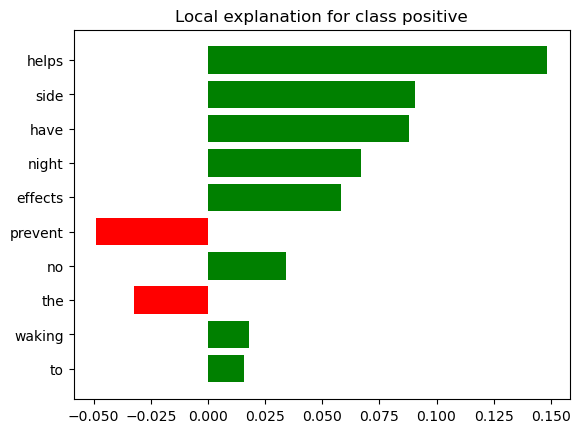

In [78]:
words = get_explainability(7,rev_drug, batch_predict)

In [79]:
words

[('helps', 0.14835507825473665),
 ('side', 0.09054582944517148),
 ('have', 0.08783081903674325),
 ('night', 0.06710881615652728),
 ('effects', 0.05830292752097214),
 ('prevent', -0.04892548947884719),
 ('no', 0.03414494391143955),
 ('the', -0.0325692199736344),
 ('waking', 0.017754470583109017),
 ('to', 0.015770395996287326)]

What if we take the positive weight words from the review, then the probability to be positive classs reduces.

In [75]:
# rid of positive weight words
list_words_remove = ['no','helps','Restoril','night','sleep']
words = get_explainability_custom(7,rev_drug,list_words_remove, batch_predict)

Review to explain: 
 me get to and prevent me from waking up constantly during the night. I have had side-effects from Restoril.
Document id: 7
Probability(positive) = 0.4204538
True class: positive


What if we take the negative weight words from the review...

In [80]:
# rid of negative weight words
list_words_remove = ['prevent','the']
words = get_explainability_custom(7,rev_drug,list_words_remove, batch_predict)

Review to explain: 
 Restoril helps me get to sleep and helps me from waking up constantly during night. I have had no side-effects from Restoril.
Document id: 7
Probability(positive) = 0.800294
True class: positive


Checking a negative label from the same drug

Review to explain: 
 Due to major anxiety and stress can&#039;t sleep before 6-7:30am was put on anti-anxiety pill and Restoril today.  The anti-anxiety pill kicked in fast and made me kinda drowsy but the Restoril 30mg I just took 45 min ago doesn&#039;t seem to be kicking in.  

Should I take another?  I do drink ale here and there but that should increase my effect not stop it right?  
Maybe I should get used to Vampire hours!! This sucks lol
Document id: 0
Probability(positive) = 0.4184363
True class: negative


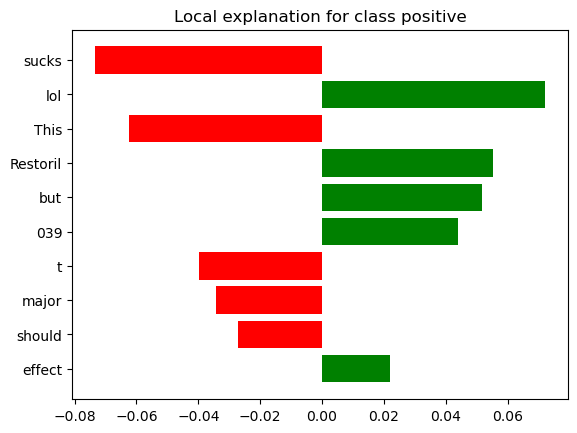

In [81]:
words_6 = get_explainability(0,rev_drug, batch_predict)

In [82]:
words_6

[('sucks', -0.07357054810615375),
 ('lol', 0.07223382541395963),
 ('This', -0.06241851711159419),
 ('Restoril', 0.05514625728319646),
 ('but', 0.051661716523048865),
 ('039', 0.0440422873066826),
 ('t', -0.03963942984835804),
 ('major', -0.034415931210943815),
 ('should', -0.027305197885713197),
 ('effect', 0.022002822487604864)]

In [83]:
# rid of positive weight words
list_words_remove = ['lol','but','Restoril','effect']
words = get_explainability_custom(0,rev_drug,list_words_remove, batch_predict)

Review to explain: 
 Due to major anxiety and stress can&#039;t sleep before 6-7:30am was put on anti-anxiety pill and today. The anti-anxiety pill kicked in fast and made me kinda drowsy the 30mg I just took 45 min ago doesn&#039;t seem to be kicking in. Should I take another? I do drink ale here and there that should increase my not stop it right? Maybe I should get used to Vampire hours!! This sucks
Document id: 0
Probability(positive) = 0.16165403
True class: negative


In [84]:
# rid of negative weight words
list_words_remove = ['sucks','This','major','should']
words = get_explainability_custom(0,rev_drug,list_words_remove, batch_predict)

Review to explain: 
 Due to anxiety and stress can&#039;t sleep before 6-7:30am was put on anti-anxiety pill and Restoril today. The anti-anxiety pill kicked in fast and made me kinda drowsy but the Restoril 30mg I just took 45 min ago doesn&#039;t seem to be kicking in. Should I take another? I do drink ale here and there but that increase my effect not stop it right? Maybe I get used to Vampire hours!! lol
Document id: 0
Probability(positive) = 0.568886
True class: negative
